In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL per month** per seller

#### Costs
_Estimated_ **reputation costs** of orders with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We make an assumption about the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
 '2 stars': 50
 '3 stars': 40
 '4 stars': 0
 '5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that have ever joined the platform, as well as with the square root of the total cumulated number of items that were ever sold.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both the number of sellers to manage and the number of sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores.
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.
- Because the carrier's delivery time is out of Olist's direct control, improving it is not a quick-win recommendation.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments in the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below.

💪 But feel free to investigate other hypothesis instead with part 3.

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worst sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` the seller brings
- the `review_costs` associated with the seller's bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need.


⚠️ Don't start from scratch, update your existing package! 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

In [4]:
from olist.seller import Seller
seller_df = Seller().get_training_data()
seller_df.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,revenues
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.000000,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.731707,0.048780,4.560976,2290.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,1.000000,NaN,5.000000,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,1.000000,NaN,5.000000,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,NaN,1.000000,1.000000,16.799


In [5]:
seller_df["revenues"] = seller_df["months_on_olist"]*80+seller_df["sales"]*0.1
seller_df["revenues"].sum()

2785818.444

In [181]:
dict_review = {5:0.075, 4:0.10, 3:0.125, 2:0.15, 1:0.20}
revenue_seller_list = []
for i in range(len(seller_df.index)):
    revenue_seller = 0
    multiplier = dict_review[round(seller_df["review_score"][i])]
    revenue_seller = seller_df["months_on_olist"][i]*80+seller_df["sales"][i]*multiplier
    revenue_seller_list.append(revenue_seller)

sum(revenue_seller_list)

2795921.503000012

In [151]:
dict_review[round(seller_df["review_score"][1])]

0.095

In [6]:
from olist.data import Olist
data = Olist().get_data()

In [7]:
data.keys()

dict_keys(['products', 'orders', 'order_items', 'geolocation', 'order_reviews', 'order_payments', 'customers', 'product_category_name_translation', 'sellers'])

In [146]:
reviews_df = data["order_reviews"]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,cost_of_reviews
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,0
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,0
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,0
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,0
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,0
...,...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30,0
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,0
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,0
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,0


In [9]:
reviews_df["cost_of_reviews"] = reviews_df["review_score"].replace([1,2,3,4,5],[100,50,40,0,0])
print(reviews_df["cost_of_reviews"].value_counts())
print(reviews_df["review_score"].value_counts())
print(reviews_df.nunique())
reviews_df["cost_of_reviews"].sum()

0      76470
100    11424
40      8179
50      3151
Name: cost_of_reviews, dtype: int64
5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64
review_id                  98410
order_id                   98673
review_score                   5
review_comment_title        4527
review_comment_message     36159
review_creation_date         636
review_answer_timestamp    98248
cost_of_reviews                4
dtype: int64


1627110

In [10]:
order_items_df = data["order_items"]
fil_order_items_df = order_items_df.loc[:,["order_id","seller_id"]]
print(fil_order_items_df.shape)
fil_order_items_df = fil_order_items_df.drop_duplicates()
print(fil_order_items_df.shape)

(112650, 2)
(100010, 2)


In [11]:
merged_df = fil_order_items_df.merge(reviews_df, how="left", on="order_id")
print(merged_df["cost_of_reviews"].sum())
print(merged_df["order_id"].count())

1632150.0
100572


In [12]:
agg_sellers_df = merged_df.groupby("seller_id").sum()
agg_sellers_df.sum()

review_score        407948.0
cost_of_reviews    1632150.0
dtype: float64

In [13]:
seller_df_v2 = seller_df.merge(agg_sellers_df["cost_of_reviews"], how="left", on="seller_id")
seller_df_v2["profits"] = seller_df_v2["revenues"]-seller_df_v2["cost_of_reviews"]

In [14]:
seller_df_v2.sum()

/tmp/ipykernel_2595/125609497.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  seller_df_v2.sum()


seller_id              3442f8959a84dea7ee197c632cb2df15d1b65fc7debc33...
seller_city            campinasmogi guacurio de janeirosao paulobraga...
seller_state           SPSPRJSPSPRJPESPSPPRGOSPSPSPSCBASCDFBASPSPSPSP...
delay_to_carrier                                             1144.182582
wait_time                                                    36017.65103
months_on_olist                                                  17878.0
n_orders                                                           99841
quantity                                                          112441
quantity_per_order                                           3433.819697
sales                                                        13555784.44
share_of_five_stars                                          1748.535826
share_of_one_stars                                            376.310285
review_score                                                12090.288256
revenues                                           

In [ ]:
seller_df_v2["order"]

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Write a function that will calculate IT costs based on two parameters: number of sellers and number of items.

2️⃣ Load the sellers data and sort them by decreasing profits (before IT costs).

3️⃣ Calculate profits:
   - Calculate the cumulative profits for each row.
   - Calculate the cumulative IT costs for each row using the function you defined before.
   - Calculate the cumulative net profit for each row.

4️⃣ Plot your results, and analyze them.

5️⃣ Determine the optimum number of sellers to keep, based on profits before and after IT costs. (Hint: look up `np.argmax`). What would have been the impact on:
   - Net profit after IT costs?
   - Net profit before IT costs
   - IT costs?
   - Total revenues?
   - Number of sellers?
   - Number of items sold?

6️⃣ How important were the IT costs in your analysis?

In [15]:
def IT_costs(num_sellers, num_items):
    return 3157.27*np.sqrt(num_sellers)+ 978.23*np.sqrt(num_items)

In [16]:
seller_df_v2 = seller_df_v2.sort_values(by=["profits"], ascending=False)
seller_df_v2 = seller_df_v2.reset_index()
seller_df_v2

,index,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,revenues,cost_of_reviews,profits
0,868,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,1.145251,222776.05,0.514706,0.100490,4.075980,23237.605,5170.0,18067.605
1,67,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,1.011905,176431.87,0.628319,0.103245,4.206490,19323.187,4700.0,14623.187
2,534,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,1.001709,194042.03,0.676976,0.085911,4.340206,21004.203,6510.0,14494.203
3,2151,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,1.054217,79284.55,0.702857,0.062857,4.434286,8808.455,1520.0,7288.455
4,2830,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,22.0,521,542,1.040307,128111.19,0.626168,0.115888,4.181308,14571.119,7500.0,7071.119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,943,1018,1.079533,17535.69,0.546351,0.130178,3.995069,2553.569,15440.0,-12886.431
2963,945,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,1146,1203,1.049738,37177.52,0.517962,0.124478,3.953216,4677.752,20220.0,-15542.248
2964,1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1706,1775,1.040445,104288.42,0.581447,0.118719,4.069575,11948.842,29530.0,-17581.158
2965,2358,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,1806,1987,1.100221,200472.92,0.477319,0.148185,3.803931,21647.292,39400.0,-17752.708


In [26]:
cum_profits = 0
cum_profits_list = []
for i in range(len(seller_df_v2.index)):
    cum_profits += seller_df_v2.iloc[i,18]
    cum_profits_list.append(cum_profits)
cum_profits_df = pd.DataFrame(cum_profits_list)

In [113]:
cum_revenues = 0
cum_revenues_list = []
for i in range(len(seller_df_v2.index)):
    cum_revenues += seller_df_v2.iloc[i,16]
    cum_revenues_list.append(cum_revenues)
cum_revenues_df = pd.DataFrame(cum_revenues_list)
cum_revenues_df

,0
0,23237.605
1,42560.792
2,63564.995
3,72373.450
4,86944.569
...,...
2962,2733774.075
2963,2738451.827
2964,2750400.669
2965,2772047.961


In [27]:
cum_profits_df

,0
0,18067.605
1,32690.792
2,47184.995
3,54473.450
4,61544.569
...,...
2962,1240004.075
2963,1224461.827
2964,1206880.669
2965,1189127.961


In [167]:
IT_costs_list = []
num_items = 0
IT_costs_cum = 0
for i in range(len(seller_df_v2.index)):
    num_items += seller_df_v2.iloc[i,9]
    IT_costs_list.append(IT_costs(i+1,num_items))

IT_costs_df = pd.DataFrame(IT_costs_list, columns=["IT_Costs_cum"])
IT_costs_df

,IT_Costs_cum
0,21666.250198
1,30235.427537
2,40453.098644
3,43500.149220
4,50434.195838
...,...
2962,470708.348497
2963,472566.543064
2964,475298.151497
2965,478162.183095


In [30]:
seller_df_v2["cum_profits"] = cum_profits_df
seller_df_v2["IT_Costs_cum"] = IT_costs_df
seller_df_v2["profits_v2"] = seller_df_v2["cum_profits"] - seller_df_v2["IT_Costs_cum"] 
seller_df_v2["profits_v2"].describe()

count    2.967000e+03
mean     8.806436e+05
std      2.664305e+05
min     -3.598645e+03
25%      7.739893e+05
50%      1.012539e+06
75%      1.073629e+06
max      1.084350e+06
Name: profits_v2, dtype: float64

In [115]:
seller_df_v2["cum_revenues"] = cum_revenues_df
seller_df_v2["final_profit_margin"] = seller_df_v2["cum_profits"] / seller_df_v2["cum_revenues"]
seller_df_v2["final_profit_margin"]

0       0.777516
1       0.768096
2       0.742311
3       0.752672
4       0.707860
          ...   
2962    0.453587
2963    0.447137
2964    0.438802
2965    0.428971
2966    0.419126
Name: final_profit_margin, Length: 2967, dtype: float64

In [117]:
fpm = seller_df_v2["final_profit_margin"]

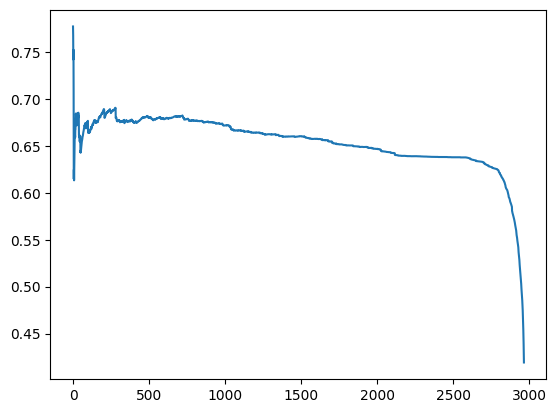

In [118]:
plt.plot(num_sellers,fpm,label="final_profit_margin")

In [123]:
print(seller_df_v2["final_profit_margin"][2500:].max())
print(seller_df_v2["final_profit_margin"][2500:].argmax())

0.6380359107941975
18


In [127]:
seller_df_v2["profits_v2"][]

2113

In [31]:
seller_df_v2["profits_v2"].argmax()

2113

In [36]:
seller_df_v2["cum_profits"].argmax()

2590

In [39]:
seller_df_v2.loc[2591,:]

index                                              2707
seller_id              1588ac4010787100dddef64568f0ae35
seller_city                                     maringa
seller_state                                         PR
delay_to_carrier                                    0.0
wait_time                                     19.871011
date_first_sale                     2017-12-22 20:50:08
date_last_sale                      2018-01-26 17:03:36
months_on_olist                                     1.0
n_orders                                              3
quantity                                              3
quantity_per_order                                  1.0
sales                                            599.97
share_of_five_stars                            0.333333
share_of_one_stars                             0.333333
review_score                                        3.0
revenues                                        139.997
cost_of_reviews                                 

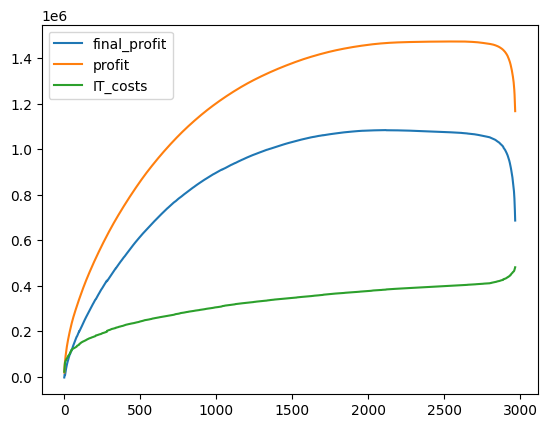

In [37]:
num_sellers = list(range(2967))
y = list(round(seller_df_v2["profits_v2"]))
y

plt.plot(num_sellers,y, label="final_profit")

z = list(round(seller_df_v2["cum_profits"]))

plt.plot(num_sellers,z,label="profit")


w = list(round(seller_df_v2["IT_Costs_cum"]))

plt.plot(num_sellers,w,label="IT_costs")

plt.legend()

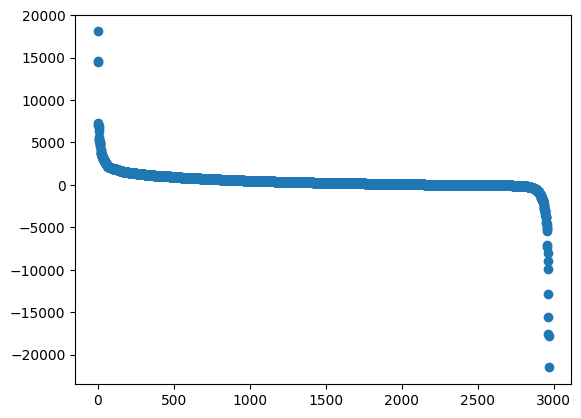

In [40]:
k = list(round(seller_df_v2["profits"]))

plt.scatter(num_sellers,k,label="profits")

/home/cazzi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

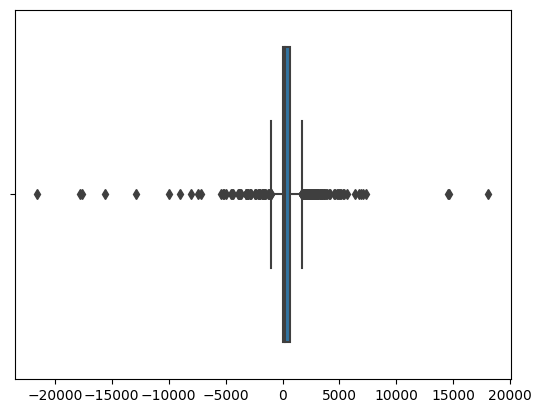

In [44]:
sns.boxplot(k)

In [58]:
seller_df_v2.iloc[2589,:]

index                                              2239
seller_id              77128dec4bec4878c37ab7d6169d6f26
seller_city                                   sao paulo
seller_state                                         SP
delay_to_carrier                                    0.0
wait_time                                     11.992465
date_first_sale                     2017-03-15 20:14:39
date_last_sale                      2017-03-15 20:14:39
months_on_olist                                     0.0
n_orders                                              1
quantity                                              1
quantity_per_order                                  1.0
sales                                               6.5
share_of_five_stars                                 1.0
share_of_one_stars                                  NaN
review_score                                        5.0
revenues                                           0.65
cost_of_reviews                                 

In [51]:
seller_df_v2["profits"].describe()

count     2967.000000
mean       393.531663
std       1250.886133
min     -21519.517000
25%         20.980000
50%        254.370000
75%        691.700000
max      18067.605000
Name: profits, dtype: float64

In [76]:
cost_of_review_analysis = seller_df_v2.copy()
cost_of_review_analysis.drop(columns = "index",inplace = True)
cost_of_review_analysis.sort_values(by=['cost_of_reviews'],ascending=False, inplace=True)
sum_cost_of_reviews = cost_of_review_analysis["cost_of_reviews"].sum()
sum_cost_of_reviews
cost_of_review_analysis["share_cost_of_reviews"] = cost_of_review_analysis["cost_of_reviews"] / sum_cost_of_reviews
cost_of_review_analysis.reset_index(inplace=True)
cost_of_review_analysis

,index,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,...,share_of_five_stars,share_of_one_stars,review_score,revenues,cost_of_reviews,profits,cum_profits,IT_Costs_cum,profits_v2,share_cost_of_reviews
0,2965,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,1806,...,0.477319,0.148185,3.803931,21647.292,39400.0,-17752.708,1189127.961,478162.183095,7.109658e+05,0.024348
1,2966,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,18.0,1854,...,0.506931,0.132178,3.909406,13770.483,35290.0,-21519.517,1167608.444,481074.512094,6.865339e+05,0.021808
2,2964,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1706,...,0.581447,0.118719,4.069575,11948.842,29530.0,-17581.158,1206880.669,475298.151497,7.315825e+05,0.018249
3,2959,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,0.0,22.392546,2017-01-26 22:55:10,2018-08-08 03:10:34,18.0,982,...,0.319678,0.236284,3.348208,20232.389,28250.0,-8017.611,1271834.193,465988.827161,8.058454e+05,0.017458
4,2961,1f50f920176fa81dab994f9023523100,sao jose do rio preto,SP,0.0,15.571831,2017-04-03 22:15:14,2018-08-28 03:45:18,17.0,1404,...,0.567288,0.145963,3.982402,12053.921,21980.0,-9926.079,1252890.506,469165.729304,7.837248e+05,0.013583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,2173,3b18f9856c6eb2413eafedb58e9eecd9,santo andre,SP,0.0,9.184120,2018-04-13 12:50:24,2018-04-13 12:50:24,0.0,1,...,1.000000,NaN,5.000000,31.500,0.0,31.500,1469417.317,386053.838925,1.083363e+06,0.000000
2963,1179,747e73c01a4593d4cf60dcf970fd2689,vitoria de santo antao,PE,0.0,10.688094,2018-03-01 09:09:14,2018-04-27 08:12:15,2.0,3,...,0.333333,NaN,4.333333,381.799,0.0,381.799,1280019.206,323363.811434,9.566554e+05,0.000000
2964,2170,c611f4ce9ce875bcc063fa97fd4d7d12,atibaia,SP,0.0,4.072801,2018-07-31 15:40:18,2018-07-31 15:40:18,0.0,1,...,NaN,NaN,4.000000,31.900,0.0,31.900,1469322.247,385940.212095,1.083382e+06,0.000000
2965,2169,eb9267cccc90f1b49c8d2f9887c7dd97,recife,PE,0.0,7.810868,2018-05-07 10:11:18,2018-05-07 10:11:18,0.0,1,...,1.000000,NaN,5.000000,31.990,0.0,31.990,1469290.347,385904.324153,1.083386e+06,0.000000


In [78]:
cum_reviewcosts = 0
cum_reviewcosts_list = []
for i in range(len(cost_of_review_analysis.index)):
    cum_reviewcosts += cost_of_review_analysis.iloc[i,22]
    cum_reviewcosts_list.append(cum_reviewcosts)
cum_reviewcosts_df = pd.DataFrame(cum_reviewcosts_list)
cum_reviewcosts_df

,0
0,0.024348
1,0.046156
2,0.064404
3,0.081862
4,0.095445
...,...
2962,1.000000
2963,1.000000
2964,1.000000
2965,1.000000


In [108]:
cum_reviewcosts_df.iloc[20,:]

0    0.233505
Name: 20, dtype: float64

In [97]:
cost_of_review_analysis.iloc[473,:]

index                                                 928
seller_id                0176f73cc1195f367f7b32db1e5b3aa8
seller_city                                      ibitinga
seller_state                                           SP
delay_to_carrier                                      0.0
wait_time                                       13.377644
date_first_sale                       2017-11-16 17:52:46
date_last_sale                        2018-08-15 03:15:30
months_on_olist                                       9.0
n_orders                                               38
quantity                                               39
quantity_per_order                               1.026316
sales                                              4733.1
share_of_five_stars                              0.589744
share_of_one_stars                               0.102564
review_score                                     4.025641
revenues                                          1193.31
cost_of_review

In [143]:
seller_df_v2[:][2966:2967]

,index,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,...,review_score,revenues,cost_of_reviews,profits,cum_profits,IT_Costs_cum,profits_v2,profit margin,cum_revenues,final_profit_margin
2966,769,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,18.0,1854,...,3.909406,13770.483,35290.0,-21519.517,1167608.444,481074.512094,686533.931906,-1.562728,2785818.444,0.419126


In [175]:
seller_df_v2["n_orders"].value_counts()

1       475
2       326
3       216
4       157
5       142
       ... 
102       1
123       1
388       1
109       1
1854      1
Name: n_orders, Length: 251, dtype: int64

/home/cazzi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


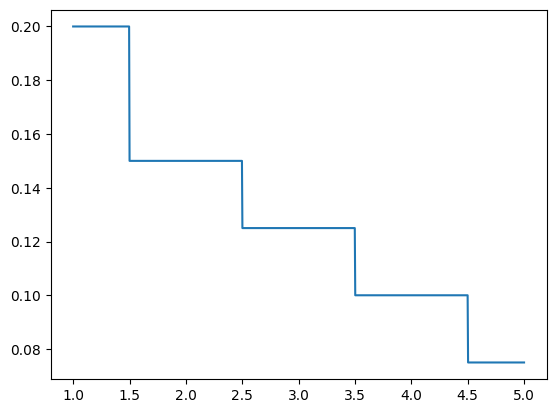

In [197]:
review_score = list(np.linspace(1,5,1000))
sales_fee = []
for i in review_score:
    sales_fee.append(dict_review[round(i)])

sns.lineplot(review_score,sales_fee,x="review_score", y="sales_fee")
plt.show()

In [219]:
fivestar_salles = seller_df_v2[round(seller_df_v2["review_score"])==5]["sales"].sum()
fivestar_salles_list = [fivestar_salles*0.9, fivestar_salles*(1-0.075)]
our_revenues = [2785818.44, 2795921.50]

fivestar_salles_list

[932066.6039999999, 957957.343]

## 3. Investigate other Approaches 🕵️
*(optional)*
ideias:
- alinhar estrutura de incentivos: dar desconto para quem tem boa avaliação e/ou tirar da plataforma quem tem baixa avaliação depois de muitas vendas

- X% (ou Y vendedores) trazem um custo reputacional de R$ Z que representa um Z% da receita

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after a honeymoon period of a few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪